# Tutorial 2 - RNN Time Series

In this notebook, we will predict the 10th day stock price. 

In [1]:
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import mean_squared_error


# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Read the Dataset

In [2]:
import pandas as pd

macys = pd.read_csv('Macys.csv')

macys.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,4/11/2022,23.889999,25.260000,23.840000,24.469999,23.675528,13911400
1,4/12/2022,24.930000,25.610001,24.709999,24.740000,23.936760,13052700
2,4/13/2022,24.650000,25.930000,24.540001,25.820000,24.981695,10878400
3,4/14/2022,25.920000,26.719999,25.750000,25.799999,24.962343,11993100
4,4/18/2022,25.660000,26.080000,25.059999,25.650000,24.817215,12717700


In [3]:
macys.shape

(256, 7)

In [4]:
macys=macys[:100]

In [5]:
# Check the data types of each column
print(macys.dtypes)



Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object


In [6]:
# Check the number of missing values in each column
print(macys.isnull().sum())



Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [7]:
# Summary statistics of the data
print(macys.describe())



             Open        High         Low       Close   Adj Close  \
count  100.000000  100.000000  100.000000  100.000000  100.000000   
mean    20.605000   21.103000   20.094500   20.589900   19.996901   
std      2.930174    3.011238    2.882786    2.932434    2.787552   
min     16.490000   16.530001   15.850000   16.260000   15.850101   
25%     18.055000   18.565000   17.500000   18.115001   17.633966   
50%     19.725001   20.180000   19.255000   19.675000   19.179012   
75%     23.525000   23.955001   22.877500   23.492501   22.729763   
max     27.040001   27.299999   26.400000   26.809999   25.939552   

             Volume  
count  1.000000e+02  
mean   1.334285e+07  
std    6.575312e+06  
min    7.000400e+06  
25%    1.010728e+07  
50%    1.193435e+07  
75%    1.355495e+07  
max    5.095580e+07  


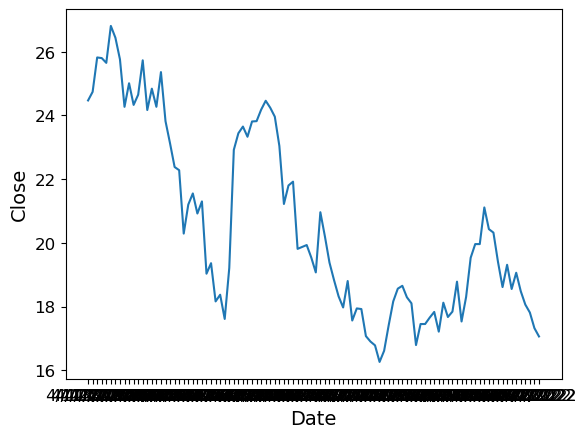

In [8]:
# Visualize the trends in the closing prices over time
import seaborn as sns
sns.lineplot(data=macys, x="Date", y="Close")
plt.show()



C:\Users\sivag\AppData\Local\Temp\ipykernel_28068\467689187.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(macys.corr())


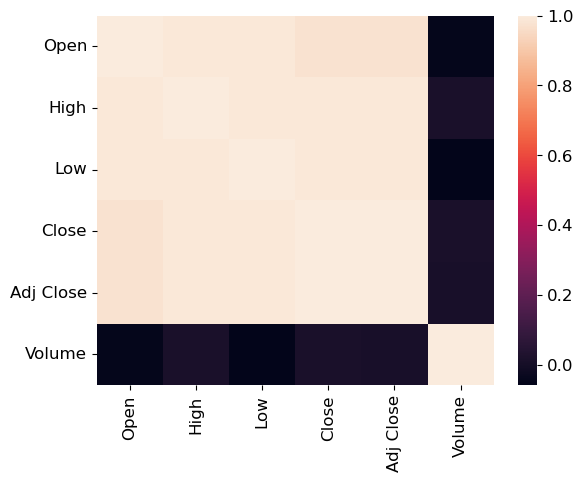

In [9]:
# Check the correlation between the closing price and other variables
sns.heatmap(macys.corr())
plt.show()

It could indicate that there is no strong correlation between any two variables in the dataset. However, it's still important to keep in mind that a lack of correlation doesn't necessarily mean that the variables are independent. There could be non-linear relationships between the variables or other factors that are not captured in the correlation analysis. It's also possible that the sample size is too small to detect significant correlations. 

For the task of predicting the 10-day closing stock price using the past 9 days' closing prices, we can drop some of the columns that are not relevant or redundant for this task.

Here are some columns that we can drop:

Date - Since we are only interested in the historical closing prices, the date column is not relevant and can be dropped.
Open, High, Low, Adj Close, and Volume - We are only interested in the Close column for predicting the closing price, so these columns are redundant and can be dropped.

In [10]:
# Drop the columns we don't need
macys = macys.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1)

In [11]:
macys

,Date,Close
0,4/11/2022,24.469999
1,4/12/2022,24.740000
2,4/13/2022,25.820000
3,4/14/2022,25.799999
4,4/18/2022,25.650000
...,...,...
95,8/26/2022,18.480000
96,8/29/2022,18.059999
97,8/30/2022,17.809999
98,8/31/2022,17.320000


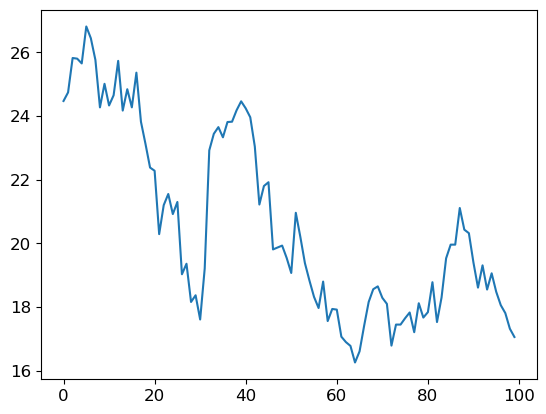

In [12]:
#Plot closing prices

plt.plot(macys['Close'])
plt.show()

# Data Cleanup

Performing data validation and cleansing to identify any potential outliers or erroneous values or extreme values that need to be investigated further or removed from the dataset.


In [13]:
# Check for outliers
q1 = macys['Close'].quantile(0.25)
q3 = macys['Close'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - (1.5 * iqr)
upper_bound = q3 + (1.5 * iqr)
outliers = macys[(macys['Close'] < lower_bound) | (macys['Close'] > upper_bound)]
print(outliers)



Empty DataFrame
Columns: [Date, Close]
Index: []


In [14]:
# Check for incorrect values
incorrect = macys[macys['Close'] < 0]
print(incorrect)



Empty DataFrame
Columns: [Date, Close]
Index: []


In [15]:
# Remove outliers and incorrect values
macys = macys[(macys['Close'] >= 0) & (macys['Close'] <= upper_bound)]

In [16]:
macys.shape


(100, 2)

In [17]:
macys

,Date,Close
0,4/11/2022,24.469999
1,4/12/2022,24.740000
2,4/13/2022,25.820000
3,4/14/2022,25.799999
4,4/18/2022,25.650000
...,...,...
95,8/26/2022,18.480000
96,8/29/2022,18.059999
97,8/30/2022,17.809999
98,8/31/2022,17.320000


The fact that the output of the describe() function did not show any values outside of the expected range for the columns indicates that there are no outliers in the dataset, and therefore no rows were removed during the data validation and cleansing step.

In [18]:
#Remove all null values
macys=macys.dropna().reset_index(drop=True)

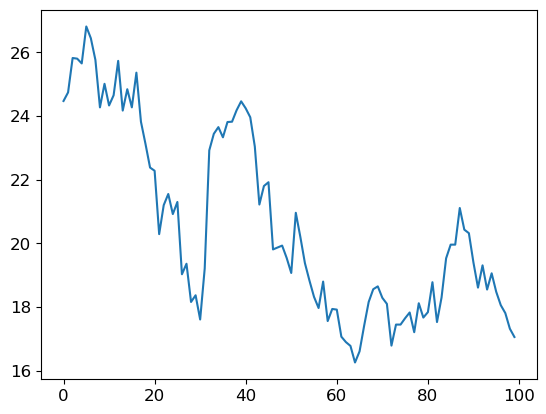

In [19]:
plt.plot(macys['Close'])
plt.show()

# Reshape the data set

In [20]:
macys.shape

(100, 2)

In [21]:
macys.shape[0]/10

10.0

In [22]:
macys.groupby(['Date']).count()

,Close
Date,
4/11/2022,1
4/12/2022,1
4/13/2022,1
4/14/2022,1
4/18/2022,1
...,...
8/4/2022,1
8/5/2022,1
8/8/2022,1


In [23]:
temp=np.array(macys['Close']).reshape(10,10)
temp

array([[24.469999, 24.74    , 25.82    , 25.799999, 25.65    , 26.809999,
        26.440001, 25.76    , 24.27    , 25.01    ],
       [24.33    , 24.65    , 25.73    , 24.17    , 24.84    , 24.27    ,
        25.360001, 23.82    , 23.120001, 22.379999],
       [22.280001, 20.290001, 21.200001, 21.549999, 20.92    , 21.299999,
        19.030001, 19.360001, 18.16    , 18.370001],
       [17.610001, 19.209999, 22.92    , 23.440001, 23.65    , 23.33    ,
        23.809999, 23.82    , 24.18    , 24.459999],
       [24.24    , 23.959999, 23.040001, 21.219999, 21.799999, 21.92    ,
        19.809999, 19.870001, 19.93    , 19.540001],
       [19.07    , 20.959999, 20.200001, 19.379999, 18.83    , 18.32    ,
        17.969999, 18.799999, 17.559999, 17.940001],
       [17.92    , 17.07    , 16.9     , 16.780001, 16.26    , 16.610001,
        17.41    , 18.16    , 18.559999, 18.65    ],
       [18.290001, 18.1     , 16.790001, 17.450001, 17.450001, 17.65    ,
        17.83    , 17.209999, 18.1200

In [24]:
# Convert to dataframe

macys_df = pd.DataFrame(temp, columns=np.arange(0,10,1))

macys_df

,0,1,2,3,4,5,6,7,8,9
0,24.469999,24.740000,25.820000,25.799999,25.650000,26.809999,26.440001,25.760000,24.270000,25.010000
1,24.330000,24.650000,25.730000,24.170000,24.840000,24.270000,25.360001,23.820000,23.120001,22.379999
2,22.280001,20.290001,21.200001,21.549999,20.920000,21.299999,19.030001,19.360001,18.160000,18.370001
3,17.610001,19.209999,22.920000,23.440001,23.650000,23.330000,23.809999,23.820000,24.180000,24.459999
4,24.240000,23.959999,23.040001,21.219999,21.799999,21.920000,19.809999,19.870001,19.930000,19.540001
5,19.070000,20.959999,20.200001,19.379999,18.830000,18.320000,17.969999,18.799999,17.559999,17.940001
6,17.920000,17.070000,16.900000,16.780001,16.260000,16.610001,17.410000,18.160000,18.559999,18.650000
7,18.290001,18.100000,16.790001,17.450001,17.450001,17.650000,17.830000,17.209999,18.120001,17.670000
8,17.840000,18.780001,17.530001,18.299999,19.530001,19.959999,19.959999,21.110001,20.430000,20.320000
9,19.400000,18.610001,19.309999,18.549999,19.059999,18.480000,18.059999,17.809999,17.320000,17.059999


# Reshape for Standardizing Data

In [25]:
# Let's create a single sequence (i.e., feature) for standardization

macys_1feature = np.array(macys_df).ravel().reshape(-1,1)

macys_1feature.shape

(100, 1)

In [26]:
macys_1feature

array([[24.469999],
       [24.74    ],
       [25.82    ],
       [25.799999],
       [25.65    ],
       [26.809999],
       [26.440001],
       [25.76    ],
       [24.27    ],
       [25.01    ],
       [24.33    ],
       [24.65    ],
       [25.73    ],
       [24.17    ],
       [24.84    ],
       [24.27    ],
       [25.360001],
       [23.82    ],
       [23.120001],
       [22.379999],
       [22.280001],
       [20.290001],
       [21.200001],
       [21.549999],
       [20.92    ],
       [21.299999],
       [19.030001],
       [19.360001],
       [18.16    ],
       [18.370001],
       [17.610001],
       [19.209999],
       [22.92    ],
       [23.440001],
       [23.65    ],
       [23.33    ],
       [23.809999],
       [23.82    ],
       [24.18    ],
       [24.459999],
       [24.24    ],
       [23.959999],
       [23.040001],
       [21.219999],
       [21.799999],
       [21.92    ],
       [19.809999],
       [19.870001],
       [19.93    ],
       [19.540001],


## Standardize the values

In [27]:
# Next, standardize

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

macys_std = scaler.fit_transform(macys_1feature)

# Reshape the data back to 24 hour format

In [28]:
macys_reshaped = macys_std.reshape(10,10)
macys_reshaped.shape

(10, 10)

In [29]:
pd.DataFrame(macys_reshaped)

,0,1,2,3,4,5,6,7,8,9
0,1.329832,1.422370,1.792520,1.785665,1.734256,2.131824,2.005014,1.771957,1.261287,1.514908
1,1.281850,1.391525,1.761675,1.227013,1.456644,1.261287,1.634864,1.107057,0.867146,0.613523
2,0.579251,-0.102785,0.209101,0.329056,0.113136,0.243373,-0.534627,-0.421525,-0.832803,-0.760829
3,-1.021306,-0.472936,0.798599,0.976820,1.048793,0.939119,1.103630,1.107057,1.230441,1.326405
4,1.251005,1.155039,0.839727,0.215955,0.414739,0.455867,-0.267297,-0.246732,-0.226169,-0.359834
5,-0.520918,0.126845,-0.133631,-0.414671,-0.603173,-0.777966,-0.897923,-0.613456,-1.038443,-0.908204
6,-0.915059,-1.206381,-1.264645,-1.305773,-1.483993,-1.364037,-1.089852,-0.832803,-0.695711,-0.664865
7,-0.788248,-0.853367,-1.302345,-1.076143,-1.076143,-1.007597,-0.945905,-1.158399,-0.846512,-1.000742
8,-0.942478,-0.620310,-1.048724,-0.784821,-0.363261,-0.215887,-0.215887,0.178255,-0.054803,-0.092503
9,-0.407816,-0.678574,-0.438662,-0.699138,-0.524345,-0.723129,-0.867077,-0.952760,-1.120698,-1.209809


# Split the Data

In this case, we are using a chronological split as it is stock market data.

In [30]:
from sklearn.model_selection import train_test_split


train, test = train_test_split(macys_reshaped,test_size=0.3)



# if we neede to maintain the ordering of the data, we can use the following code to split the data
#split_point = int(len(temp_reshaped)*0.7)
#train, test = temp_reshaped[:split_point], temp_reshaped[split_point:]

In [31]:
train.shape

(7, 10)

In [32]:
train[:2]

array([[ 1.32983248,  1.42237035,  1.79252046,  1.78566549,  1.73425609,
         2.13182439,  2.00501439,  1.77195657,  1.26128651,  1.51490788],
       [-0.78824802, -0.85336737, -1.3023454 , -1.07614255, -1.07614255,
        -1.00759658, -0.9459049 , -1.15839882, -0.84651239, -1.00074195]])

In [33]:
test.shape

(3, 10)

In [34]:
test[:2]

array([[-0.94247758, -0.62030955, -1.04872403, -0.78482139, -0.36326086,
        -0.21588696, -0.21588696,  0.17825504, -0.05480278, -0.09250325],
       [ 1.2818504 ,  1.39152451,  1.76167462,  1.22701335,  1.45664351,
         1.26128651,  1.63486427,  1.10705729,  0.86714553,  0.61352347]])

# Create Input and Target values

The 9 day price to predict 10th day price(i.e., target)

In [35]:
# The first 9 columns (from 0 to 9) are inputs

train_inputs = train[:,:9]

pd.DataFrame(train_inputs, columns=np.arange(0,9,1))

,0,1,2,3,4,5,6,7,8
0,1.329832,1.422370,1.792520,1.785665,1.734256,2.131824,2.005014,1.771957,1.261287
1,-0.788248,-0.853367,-1.302345,-1.076143,-1.076143,-1.007597,-0.945905,-1.158399,-0.846512
2,0.579251,-0.102785,0.209101,0.329056,0.113136,0.243373,-0.534627,-0.421525,-0.832803
3,-0.407816,-0.678574,-0.438662,-0.699138,-0.524345,-0.723129,-0.867077,-0.952760,-1.120698
4,1.251005,1.155039,0.839727,0.215955,0.414739,0.455867,-0.267297,-0.246732,-0.226169
5,-1.021306,-0.472936,0.798599,0.976820,1.048793,0.939119,1.103630,1.107057,1.230441
6,-0.915059,-1.206381,-1.264645,-1.305773,-1.483993,-1.364037,-1.089852,-0.832803,-0.695711


## Add one more dimension to make it ready for RNNs

See here for more details: https://keras.io/layers/recurrent/, and https://shiva-verma.medium.com/understanding-input-and-output-shape-in-lstm-keras-c501ee95c65e


In [36]:
train_inputs

array([[ 1.32983248,  1.42237035,  1.79252046,  1.78566549,  1.73425609,
         2.13182439,  2.00501439,  1.77195657,  1.26128651],
       [-0.78824802, -0.85336737, -1.3023454 , -1.07614255, -1.07614255,
        -1.00759658, -0.9459049 , -1.15839882, -0.84651239],
       [ 0.579251  , -0.10278486,  0.20910089,  0.32905625,  0.1131357 ,
         0.24337336, -0.53462665, -0.42152523, -0.83280347],
       [-0.40781631, -0.67857392, -0.43866249, -0.6991385 , -0.52434539,
        -0.72312937, -0.86707697, -0.95275987, -1.120698  ],
       [ 1.25100456,  1.15503937,  0.839727  ,  0.21595483,  0.41473915,
         0.45586728, -0.2672967 , -0.24673212, -0.22616857],
       [-1.0213055 , -0.47293565,  0.79859887,  0.97681963,  1.04879292,
         0.93911882,  1.10362963,  1.10705729,  1.23044066],
       [-0.91505905, -1.2063809 , -1.26464527, -1.30577272, -1.48399348,
        -1.36403708, -1.08985216, -0.83280347, -0.69571118]])

In [37]:
train_inputs.shape 

(7, 9)

In [38]:
#Create an additional dimension for train

train_x = train_inputs[:,:,np.newaxis]

train_x.shape 

(7, 9, 1)

In [39]:
train_x

array([[[ 1.32983248],
        [ 1.42237035],
        [ 1.79252046],
        [ 1.78566549],
        [ 1.73425609],
        [ 2.13182439],
        [ 2.00501439],
        [ 1.77195657],
        [ 1.26128651]],

       [[-0.78824802],
        [-0.85336737],
        [-1.3023454 ],
        [-1.07614255],
        [-1.07614255],
        [-1.00759658],
        [-0.9459049 ],
        [-1.15839882],
        [-0.84651239]],

       [[ 0.579251  ],
        [-0.10278486],
        [ 0.20910089],
        [ 0.32905625],
        [ 0.1131357 ],
        [ 0.24337336],
        [-0.53462665],
        [-0.42152523],
        [-0.83280347]],

       [[-0.40781631],
        [-0.67857392],
        [-0.43866249],
        [-0.6991385 ],
        [-0.52434539],
        [-0.72312937],
        [-0.86707697],
        [-0.95275987],
        [-1.120698  ]],

       [[ 1.25100456],
        [ 1.15503937],
        [ 0.839727  ],
        [ 0.21595483],
        [ 0.41473915],
        [ 0.45586728],
        [-0.2672967 ],
   

## Set the target

In [40]:
# The last column (9) is TARGET

train_target = train[:,-1]


pd.DataFrame(train_target, columns=['9'])

,9
0,1.514908
1,-1.000742
2,-0.760829
3,-1.209809
4,-0.359834
5,1.326405
6,-0.664865


## Repeat for TEST

In [41]:
test.shape

(3, 10)

In [42]:
# The first 9 columns (from 0 to 8) are inputs

test_inputs = test[:,:9]

In [43]:
#Create an additional dimension for test

test_x = test_inputs[:,:,np.newaxis]

test_x.shape 

(3, 9, 1)

In [44]:
# The last column (23) is TARGET

test_target = test[:,-1]


pd.DataFrame(test_target, columns=['9'])

,9
0,-0.092503
1,0.613523
2,-0.908204


In [48]:
performance = pd.DataFrame({"model":[], "MSE":[]})

# A normal (cross-sectional) NN

This model assumes that the data is NOT a time-series data set. It treats the data as cross-sectional and the columns being independent of each other.

In [50]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[9, 1]),
    keras.layers.Dense(23, activation='relu'),
    keras.layers.Dense(1, activation=None)
    
])

model.compile(loss="mse", optimizer='Adam')

history = model.fit(train_x, train_target, epochs=100)

Epoch 1/100
1/1 [==============================] - 0s 284ms/step - loss: 2.7192
Epoch 2/100
1/1 [==============================] - 0s 4ms/step - loss: 2.6273
Epoch 3/100
1/1 [==============================] - 0s 4ms/step - loss: 2.5372
Epoch 4/100
1/1 [==============================] - 0s 6ms/step - loss: 2.4506
Epoch 5/100
1/1 [==============================] - 0s 4ms/step - loss: 2.3658
Epoch 6/100
1/1 [==============================] - 0s 6ms/step - loss: 2.2828
Epoch 7/100
1/1 [==============================] - 0s 6ms/step - loss: 2.2016
Epoch 8/100
1/1 [==============================] - 0s 3ms/step - loss: 2.1225
Epoch 9/100
1/1 [==============================] - 0s 4ms/step - loss: 2.0454
Epoch 10/100
1/1 [==============================] - 0s 5ms/step - loss: 1.9705
Epoch 11/100
1/1 [==============================] - 0s 5ms/step - loss: 1.8976
Epoch 12/100
1/1 [==============================] - 0s 4ms/step - loss: 1.8262
Epoch 13/100
1/1 [==============================] - 0s 3ms/

### Predictions

In [51]:
#Predict:
y_pred = model.predict(test_x)

1/1 [==============================] - 0s 71ms/step


In [52]:
# Remember, these are standardized values. 

comparison = pd.DataFrame()

comparison['actual'] = scaler.inverse_transform([test_target]).flatten()
comparison['predicted'] = scaler.inverse_transform(y_pred).flatten()

In [53]:
comparison

,actual,predicted
0,20.320000,19.273226
1,22.379999,23.644640
2,17.940001,19.659782


In [54]:
MSE=mean_squared_error(comparison['actual'], comparison['predicted'])

In [55]:
performance = pd.concat([performance,pd.DataFrame({'model': 'Normal NN', 'MSE':MSE}, index=[0])])
performance

,model,MSE
0,Normal NN,1.884234


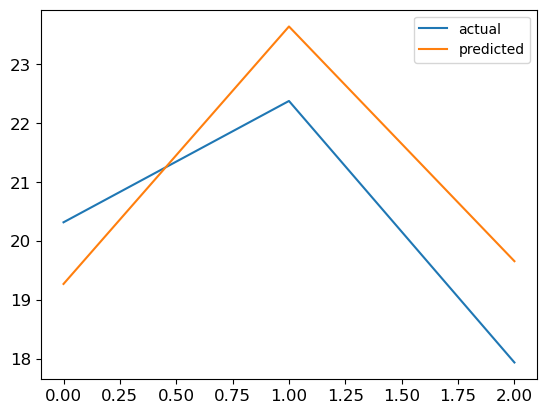

In [56]:
plt.plot(comparison['actual'], label = 'actual')
plt.plot(comparison['predicted'], label = 'predicted')

plt.legend()

plt.show()

# Simple RNN

Simplest recurrent neural network

In [57]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(32, activation='relu', input_shape=[9, 1]),
    keras.layers.Dense(1, activation=None)
])

In [59]:
np.random.seed(42)
tf.random.set_seed(42)

model.compile(loss="mse", optimizer='Adam')

history = model.fit(train_x, train_target, epochs=100)

Epoch 1/100
1/1 [==============================] - 1s 883ms/step - loss: 0.1071
Epoch 2/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0891
Epoch 3/100
1/1 [==============================] - 0s 8ms/step - loss: 0.0763
Epoch 4/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0671
Epoch 5/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0593
Epoch 6/100
1/1 [==============================] - 0s 7ms/step - loss: 0.0521
Epoch 7/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0452
Epoch 8/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0393
Epoch 9/100
1/1 [==============================] - 0s 7ms/step - loss: 0.0345
Epoch 10/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0306
Epoch 11/100
1/1 [==============================] - 0s 8ms/step - loss: 0.0276
Epoch 12/100
1/1 [==============================] - 0s 8ms/step - loss: 0.0252
Epoch 13/100
1/1 [==============================] - 0s 7ms/

### Predictions

In [60]:
#Predict:
y_pred = model.predict(test_x)

1/1 [==============================] - 0s 170ms/step


In [61]:
#Remember, these are standardized values. 

comparison = pd.DataFrame()

comparison['actual'] = scaler.inverse_transform([test_target]).flatten()
comparison['predicted'] = scaler.inverse_transform(y_pred).flatten()

In [62]:
comparison

,actual,predicted
0,20.320000,21.014896
1,22.379999,23.526215
2,17.940001,17.727516


In [63]:
MSE=mean_squared_error(comparison['actual'], comparison['predicted'])

In [64]:
performance = pd.concat([performance,pd.DataFrame({'model': 'Simple NN', 'MSE':MSE}, index=[0])])
performance

,model,MSE
0,Normal NN,1.884234
0,Simple NN,0.613947


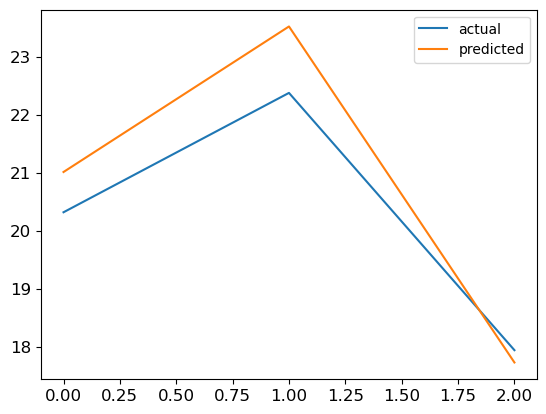

In [65]:
plt.plot(comparison['actual'], label = 'actual')
plt.plot(comparison['predicted'], label = 'predicted')

plt.legend()

plt.show()

## Simple RNN with more layers

In [66]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(32, activation='relu', return_sequences=True, input_shape=[9, 1]),
    keras.layers.SimpleRNN(32, activation='relu', return_sequences=False),
    keras.layers.Dense(1, activation=None)
])

In [68]:
np.random.seed(42)
tf.random.set_seed(42)

model.compile(loss="mse", optimizer='Adam')

history = model.fit(train_x, train_target, epochs=100)

Epoch 1/100
1/1 [==============================] - 1s 1s/step - loss: 0.0589
Epoch 2/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0428
Epoch 3/100
1/1 [==============================] - 0s 7ms/step - loss: 0.0287
Epoch 4/100
1/1 [==============================] - 0s 8ms/step - loss: 0.0198
Epoch 5/100
1/1 [==============================] - 0s 8ms/step - loss: 0.0164
Epoch 6/100
1/1 [==============================] - 0s 8ms/step - loss: 0.0154
Epoch 7/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0146
Epoch 8/100
1/1 [==============================] - 0s 8ms/step - loss: 0.0135
Epoch 9/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0116
Epoch 10/100
1/1 [==============================] - 0s 7ms/step - loss: 0.0087
Epoch 11/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0064
Epoch 12/100
1/1 [==============================] - 0s 7ms/step - loss: 0.0059
Epoch 13/100
1/1 [==============================] - 0s 8ms/ste

### Predictions

In [69]:
#Predict:
y_pred = model.predict(test_x)


1/1 [==============================] - 0s 144ms/step


In [70]:
#Remember, these are standardized values. 

comparison = pd.DataFrame()

comparison['actual'] = scaler.inverse_transform([test_target]).flatten()
comparison['predicted'] = scaler.inverse_transform(y_pred).flatten()

In [71]:
comparison

,actual,predicted
0,20.320000,20.010345
1,22.379999,23.534973
2,17.940001,17.800619


In [72]:
MSE=mean_squared_error(comparison['actual'], comparison['predicted'])

In [73]:
performance = pd.concat([performance,pd.DataFrame({'model': 'Simple RNN with more layers', 'MSE':MSE}, index=[0])])
performance

,model,MSE
0,Normal NN,1.884234
0,Simple NN,0.613947
0,Simple RNN with more layers,0.483093


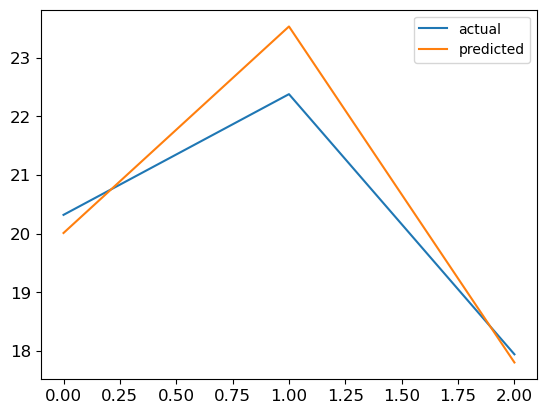

In [74]:
plt.plot(comparison['actual'], label = 'actual')
plt.plot(comparison['predicted'], label = 'predicted')

plt.legend()

plt.show()

# LSTM with one layer

In [75]:
model = keras.models.Sequential([
    keras.layers.LSTM(32, activation='relu', input_shape=[9, 1]),
    keras.layers.Dense(1, activation=None)
])

In [77]:
np.random.seed(42)
tf.random.set_seed(42)

model.compile(loss="mse", optimizer='Adam')

history = model.fit(train_x, train_target, epochs=100)

Epoch 1/100
1/1 [==============================] - 1s 832ms/step - loss: 0.3908
Epoch 2/100
1/1 [==============================] - 0s 7ms/step - loss: 0.3740
Epoch 3/100
1/1 [==============================] - 0s 9ms/step - loss: 0.3590
Epoch 4/100
1/1 [==============================] - 0s 8ms/step - loss: 0.3462
Epoch 5/100
1/1 [==============================] - 0s 7ms/step - loss: 0.3355
Epoch 6/100
1/1 [==============================] - 0s 8ms/step - loss: 0.3267
Epoch 7/100
1/1 [==============================] - 0s 6ms/step - loss: 0.3188
Epoch 8/100
1/1 [==============================] - 0s 8ms/step - loss: 0.3105
Epoch 9/100
1/1 [==============================] - 0s 8ms/step - loss: 0.3013
Epoch 10/100
1/1 [==============================] - 0s 7ms/step - loss: 0.2914
Epoch 11/100
1/1 [==============================] - 0s 8ms/step - loss: 0.2814
Epoch 12/100
1/1 [==============================] - 0s 7ms/step - loss: 0.2717
Epoch 13/100
1/1 [==============================] - 0s 8ms/

### Predictions

In [78]:
#Predict:
y_pred = model.predict(test_x)


1/1 [==============================] - 0s 103ms/step


In [79]:
#Remember, these are standardized values. 

comparison = pd.DataFrame()

comparison['actual'] = scaler.inverse_transform([test_target]).flatten()
comparison['predicted'] = scaler.inverse_transform(y_pred).flatten()

In [80]:
MSE=mean_squared_error(comparison['actual'], comparison['predicted'])

In [81]:
performance = pd.concat([performance,pd.DataFrame({'model': 'LSTM RNN', 'MSE':MSE}, index=[0])])
performance

,model,MSE
0,Normal NN,1.884234
0,Simple NN,0.613947
0,Simple RNN with more layers,0.483093
0,LSTM RNN,0.345225


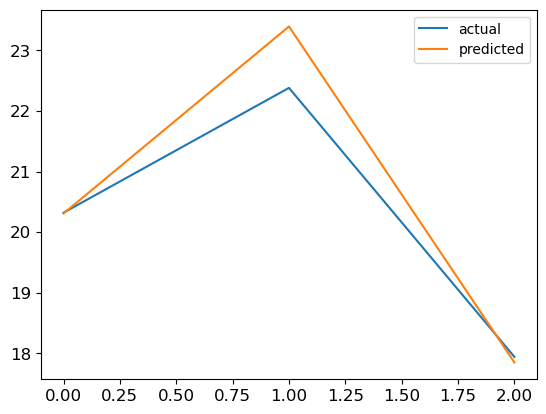

In [82]:
plt.plot(comparison['actual'], label = 'actual')
plt.plot(comparison['predicted'], label = 'predicted')

plt.legend()

plt.show()

# LSTM with more layers

In [83]:
model = keras.models.Sequential([
    keras.layers.LSTM(32, activation='tanh', return_sequences=True, input_shape=[9, 1]),
    keras.layers.LSTM(32, activation='tanh', return_sequences=False),
    keras.layers.Dense(1, activation=None)
])

In [84]:
np.random.seed(42)
tf.random.set_seed(42)

model.compile(loss="mse", optimizer='Adam')

history = model.fit(train_x, train_target, epochs=100)

Epoch 1/100
1/1 [==============================] - 3s 3s/step - loss: 0.9464
Epoch 2/100
1/1 [==============================] - 0s 9ms/step - loss: 0.8976
Epoch 3/100
1/1 [==============================] - 0s 10ms/step - loss: 0.8503
Epoch 4/100
1/1 [==============================] - 0s 11ms/step - loss: 0.8042
Epoch 5/100
1/1 [==============================] - 0s 11ms/step - loss: 0.7592
Epoch 6/100
1/1 [==============================] - 0s 10ms/step - loss: 0.7153
Epoch 7/100
1/1 [==============================] - 0s 9ms/step - loss: 0.6726
Epoch 8/100
1/1 [==============================] - 0s 10ms/step - loss: 0.6310
Epoch 9/100
1/1 [==============================] - 0s 10ms/step - loss: 0.5907
Epoch 10/100
1/1 [==============================] - 0s 9ms/step - loss: 0.5517
Epoch 11/100
1/1 [==============================] - 0s 9ms/step - loss: 0.5142
Epoch 12/100
1/1 [==============================] - 0s 11ms/step - loss: 0.4785
Epoch 13/100
1/1 [==============================] - 0s 

### Predictions

In [85]:
#Predict:
y_pred = model.predict(test_x)

1/1 [==============================] - 1s 614ms/step


In [86]:
#Remember, these are standardized values. 

comparison = pd.DataFrame()

comparison['actual'] = scaler.inverse_transform([test_target]).flatten()
comparison['predicted'] = scaler.inverse_transform(y_pred).flatten()

In [87]:
MSE=mean_squared_error(comparison['actual'], comparison['predicted'])

In [88]:
performance = pd.concat([performance,pd.DataFrame({'model': 'LSTM RNN with more layers', 'MSE':MSE}, index=[0])])
performance

,model,MSE
0,Normal NN,1.884234
0,Simple NN,0.613947
0,Simple RNN with more layers,0.483093
0,LSTM RNN,0.345225
0,LSTM RNN with more layers,1.107334


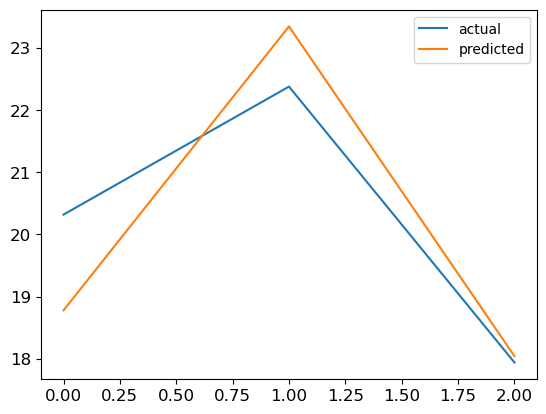

In [89]:
plt.plot(comparison['actual'], label = 'actual')
plt.plot(comparison['predicted'], label = 'predicted')

plt.legend()

plt.show()

# GRU (with more layers)

In [90]:
model = keras.models.Sequential([
    keras.layers.GRU(32, activation='relu', return_sequences=True, input_shape=[9, 1]),
    keras.layers.GRU(32, activation='relu', return_sequences=False),
    keras.layers.Dense(1, activation=None)
])

In [91]:
np.random.seed(42)
tf.random.set_seed(42)

model.compile(loss="mse", optimizer='RMSprop')

history = model.fit(train_x, train_target, epochs=100)

Epoch 1/100
1/1 [==============================] - 2s 2s/step - loss: 1.2934
Epoch 2/100
1/1 [==============================] - 0s 18ms/step - loss: 1.1546
Epoch 3/100
1/1 [==============================] - 0s 15ms/step - loss: 1.0601
Epoch 4/100
1/1 [==============================] - 0s 14ms/step - loss: 0.9844
Epoch 5/100
1/1 [==============================] - 0s 13ms/step - loss: 0.9195
Epoch 6/100
1/1 [==============================] - 0s 15ms/step - loss: 0.8614
Epoch 7/100
1/1 [==============================] - 0s 18ms/step - loss: 0.8103
Epoch 8/100
1/1 [==============================] - 0s 13ms/step - loss: 0.7635
Epoch 9/100
1/1 [==============================] - 0s 11ms/step - loss: 0.7215
Epoch 10/100
1/1 [==============================] - 0s 11ms/step - loss: 0.6818
Epoch 11/100
1/1 [==============================] - 0s 14ms/step - loss: 0.6432
Epoch 12/100
1/1 [==============================] - 0s 13ms/step - loss: 0.6046
Epoch 13/100
1/1 [==============================] -

### Predictions

In [92]:
#Predict:
y_pred = model.predict(test_x)

1/1 [==============================] - 0s 183ms/step


In [93]:
#Remember, these are standardized values. 

comparison = pd.DataFrame()

comparison['actual'] = scaler.inverse_transform([test_target]).flatten()
comparison['predicted'] = scaler.inverse_transform(y_pred).flatten()

In [94]:
MSE=mean_squared_error(comparison['actual'], comparison['predicted'])

In [95]:
performance = pd.concat([performance,pd.DataFrame({'model': 'GRU with more layers', 'MSE':MSE}, index=[0])])
performance

,model,MSE
0,Normal NN,1.884234
0,Simple NN,0.613947
0,Simple RNN with more layers,0.483093
0,LSTM RNN,0.345225
0,LSTM RNN with more layers,1.107334
0,GRU with more layers,1.010166


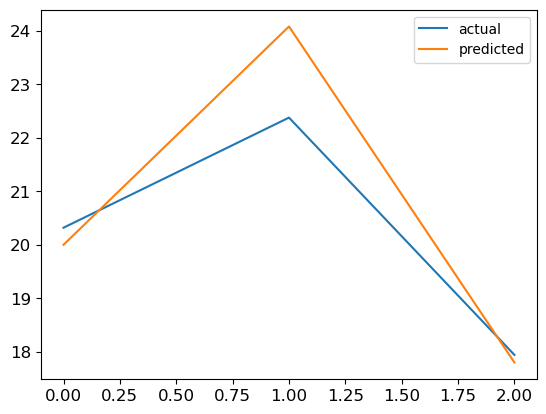

In [96]:
plt.plot(comparison['actual'], label = 'actual')
plt.plot(comparison['predicted'], label = 'predicted')

plt.legend()

plt.show()

# Conv1D

### Last Layer: GRU (you can change it to SimpleRNN or LSTM as well)

In [97]:
model = keras.models.Sequential([
    keras.layers.Conv1D(filters=20, kernel_size=3, strides=1, padding="valid", input_shape=[9, 1]),
    keras.layers.GRU(32, activation='relu', return_sequences=True),
    keras.layers.GRU(32, activation='relu', return_sequences=False),
    keras.layers.Dense(1, activation=None)
])

In [99]:
np.random.seed(42)
tf.random.set_seed(42)

model.compile(loss="mse", optimizer='Adam')

history = model.fit(train_x, train_target, epochs=100)

Epoch 1/100
1/1 [==============================] - 2s 2s/step - loss: 0.0979
Epoch 2/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0885
Epoch 3/100
1/1 [==============================] - 0s 8ms/step - loss: 0.0829
Epoch 4/100
1/1 [==============================] - 0s 16ms/step - loss: 0.0777
Epoch 5/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0725
Epoch 6/100
1/1 [==============================] - 0s 8ms/step - loss: 0.0680
Epoch 7/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0646
Epoch 8/100
1/1 [==============================] - 0s 8ms/step - loss: 0.0615
Epoch 9/100
1/1 [==============================] - 0s 8ms/step - loss: 0.0588
Epoch 10/100
1/1 [==============================] - 0s 8ms/step - loss: 0.0563
Epoch 11/100
1/1 [==============================] - 0s 9ms/step - loss: 0.0539
Epoch 12/100
1/1 [==============================] - 0s 7ms/step - loss: 0.0516
Epoch 13/100
1/1 [==============================] - 0s 6ms/

### Predictions

In [100]:
#Predict:
y_pred = model.predict(test_x)

1/1 [==============================] - 0s 273ms/step


In [101]:
#Remember, these are standardized values. 

comparison = pd.DataFrame()

comparison['actual'] = scaler.inverse_transform([test_target]).flatten()
comparison['predicted'] = scaler.inverse_transform(y_pred).flatten()

In [102]:
MSE=mean_squared_error(comparison['actual'], comparison['predicted'])

In [103]:
performance = pd.concat([performance,pd.DataFrame({'model': 'Conv 1D', 'MSE':MSE}, index=[0])])
performance

,model,MSE
0,Normal NN,1.884234
0,Simple NN,0.613947
0,Simple RNN with more layers,0.483093
0,LSTM RNN,0.345225
0,LSTM RNN with more layers,1.107334
0,GRU with more layers,1.010166
0,Conv 1D,1.256868


In [104]:
performance.sort_values(by='MSE')

,model,MSE
0,LSTM RNN,0.345225
0,Simple RNN with more layers,0.483093
0,Simple NN,0.613947
0,GRU with more layers,1.010166
0,LSTM RNN with more layers,1.107334
0,Conv 1D,1.256868
0,Normal NN,1.884234


Based on the above performance metrics, the model with the lowest mean squared error (MSE) value is the LSTM RNN with an MSE of 0.345225. This suggests that it is the most accurate model for predicting the 10-day closing stock price using the past nine days of data.

The Simple RNN with more layers and the Simple NN come next in terms of performance, with MSE values of 0.483093 and 0.613947, respectively. These models are also quite accurate, although not as good as the LSTM RNN.

The GRU with more layers, LSTM RNN with more layers, Conv 1D, and Normal NN models have MSE values of 1.010166, 1.107334, 1.256868, and 1.884234, respectively. These models appear to have lower performance than the previously mentioned models, with the Normal NN performing the worst out of all the models.

Overall, it seems that the LSTM RNN is the best performing model for predicting the 10-day closing stock price using the past nine days of data, followed by the Simple RNN with more layers and the Simple NN.